# 分群(Clustering)
1. 目標: 
    - 群內相似度很高
    - 群間相似度很低
2. 主要影響因子: 
    - 相似度的衡量與實作
    - 演算法
3. 應用面: 
    - 市場區隔
    - 生物分群
    - 新聞分群
    - 圖片標記

# 距離的定義
1. Euclidean distance(歐基里德距離)
    - $d(i, j) = \sqrt{|x_{i1} - x_{j1}|^2 + |x_{i2} - x_{j2}|^2 + \dots + |x_{in} - x_{jn}|^2}$
2. Manhattan (city block) distance(曼哈頓距離)
    - $d(i, j) = |x_{i1} - x_{j1}| + |x_{i2} - x_{j2}| + \dots + |x_{in} - x_{jn}|$
3. Minkowski distance
    - $d(i, j) = \sqrt[q]{|x_{i1} - x_{j1}|^q + |x_{i2} - x_{j2}|^q + \dots + |x_{in} - x_{jn}|^q}$
4. Weighted Manhattan distance(加權曼哈頓距離)
    - $d(i, j) = \sqrt[q]{w1|x_{i1} - x_{j1}|^q + w2|x_{i2} - x_{j2}|^q + \dots + w3|x_{in} - x_{jn}|^q}$


# IMPORT & DATA

In [1]:
import os
import numpy as np
import pandas as pd
from collections import Counter
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN # Clustering Algorithms

from mpl_toolkits.mplot3d import Axes3D
from sklearn import datasets
from sklearn.decomposition import PCA

# self defined function
np.random.seed(1212)
from load_all_datasets import load
from planar_utils import plot_decision_boundary, sigmoid, load_planar_dataset, load_extra_datasets

flower


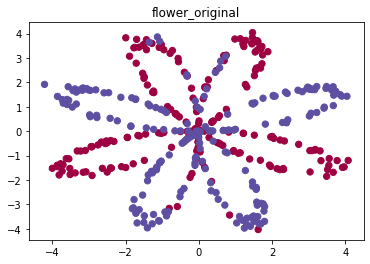

noisy_circles


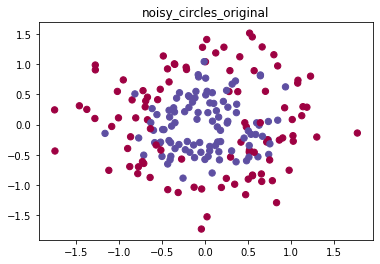

noisy_moons


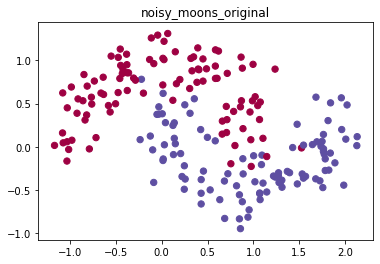

blobs


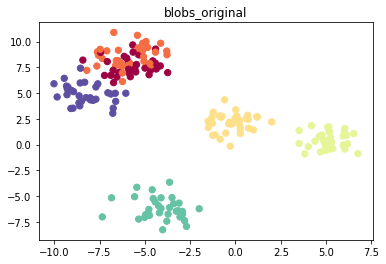

gaussian_quantiles


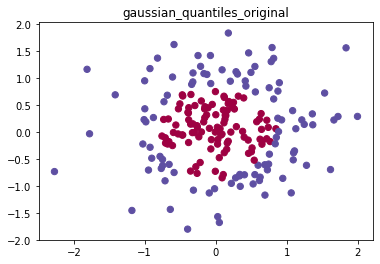

In [2]:
# demo用資料
datas = load()

for name, X, Y in datas:
    print(name)
    plt.scatter(X[:, 0], X[:, 1], c=Y , s=40, cmap=plt.cm.Spectral);
    plt.title(name+'_original')
    plt.show()

In [3]:
# 練習用資料
iris = datasets.load_iris()
df_iris = pd.DataFrame(iris.data, columns=iris['feature_names'])
df_iris['target'] = list(map(lambda x:iris.target_names[x], iris.target))
df_iris.head()


,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),target
0,5.1,3.5,1.4,0.2,setosa
1,4.9,3.0,1.4,0.2,setosa
2,4.7,3.2,1.3,0.2,setosa
3,4.6,3.1,1.5,0.2,setosa
4,5.0,3.6,1.4,0.2,setosa


In [4]:
df_iris.groupby('target').count()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm)
target,,,,
setosa,50,50,50,50
versicolor,50,50,50,50
virginica,50,50,50,50


In [5]:
df_iris.groupby('target').sum()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm)
target,,,,
setosa,250.3,171.4,73.1,12.3
versicolor,296.8,138.5,213.0,66.3
virginica,329.4,148.7,277.6,101.3


In [73]:
df_iris.groupby('target').mean()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm)
target,,,,
setosa,5.006,3.428,1.462,0.246
versicolor,5.936,2.770,4.260,1.326
virginica,6.588,2.974,5.552,2.026


In [6]:
# 簡單資料探索
# 請找出每一個target(花的類別)的種類各有幾筆資料(hint: groupby)
#!=============your works starts===============!#
df_iris.groupby('target').count()
#!==============your works ends================!#

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm)
target,,,,
setosa,50,50,50,50
versicolor,50,50,50,50
virginica,50,50,50,50


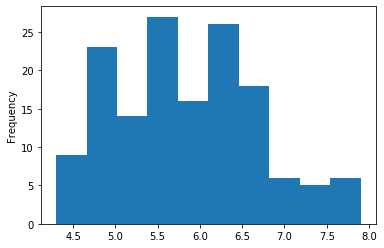

In [8]:
#請畫出['sepal length (cm)']的分布狀況
#!=============your works starts===============!#
df_iris['sepal length (cm)'].plot(kind='hist')
#!==============your works ends================!#

plt.show()

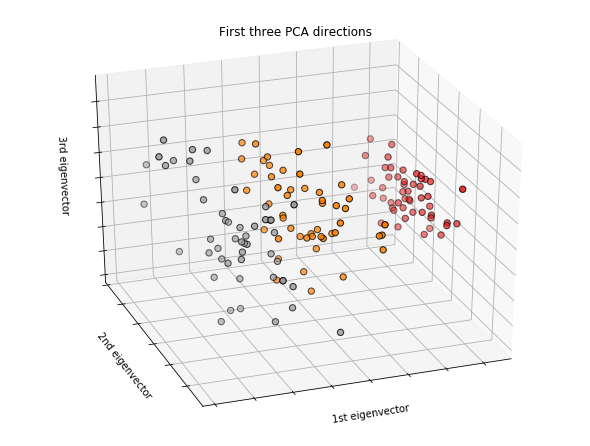

In [15]:
iris_X = df_iris[["sepal length (cm)", "sepal width (cm)", "petal length (cm)", "petal width (cm)"]].values
iris_Y = iris.target

X = iris_X
Y = iris_Y

#請使用PCA畫出不同花在三維空間中的分布位置(請上網尋找PCA的程式碼，並複製過來)
#!=============your works starts===============!#
# predict
   
fig = plt.figure(1, figsize=(8, 6))
ax = Axes3D(fig, elev=-150, azim=110)
X_reduced = PCA(n_components=3).fit_transform(X)
ax.scatter(X_reduced[:, 0], X_reduced[:, 1], X_reduced[:, 2], c=Y,
           cmap=plt.cm.Set1, edgecolor='k', s=40)
ax.set_title("First three PCA directions")
ax.set_xlabel("1st eigenvector")
ax.w_xaxis.set_ticklabels([])
ax.set_ylabel("2nd eigenvector")
ax.w_yaxis.set_ticklabels([])
ax.set_zlabel("3rd eigenvector")
ax.w_zaxis.set_ticklabels([])

#!==============your works ends================!#

plt.show()

# ALGORITHM

## 1. K-means
### steps
1. 設定重心: 
    - 決定要分幾個群(e.g. K群)
    - 隨機產生K個重心
2. 分群: 
    - 找到所有資料點歸屬的重心: 找到分別最靠近這三個點的所有資料點，並做第一個迴圈的分群
3. 尋找重心: 
    - 重新計算所有資料點的重心(element-wise的平均)
4. ....
5. 停止: 
    - 重複上述方法，只到不會有資料點因為重新尋找重心而改變群組

### visualize
1. web: 

[game](http://stanford.edu/class/ee103/visualizations/kmeans/kmeans.html)

2. GIF: 

![kmeans](./imgs/kmeans.gif)

### parameters
|參數 | 意義|
|--- | ---|
|n_cluster | 要分成幾個群|
|random_state | 決定初始點的隨機seed|

### pros & cons
1. 一開始需要決定要分成幾個群


1. 優點
    - 效率: 時間複雜度O(tkn)。n是資料點的個數，k是群的個數，t是迴圈的個數，一班來說: k, t << n。 
2. 缺點
    - 需要指定分成幾群
    - 無法處理具有雜訊(noisy)的資料及離群值(outliers)
    - 無法處理不同大小及不同密度的群
    
    ![KmeansCon1.JPG](./imgs/KmeansCon1.JPG)
    
    - 無法發現凸多邊形(non-convex)以外的群
    
    ![KmeansCon2.JPG](./imgs/KmeansCon2.JPG)
    
    - 通常在local optimum停止



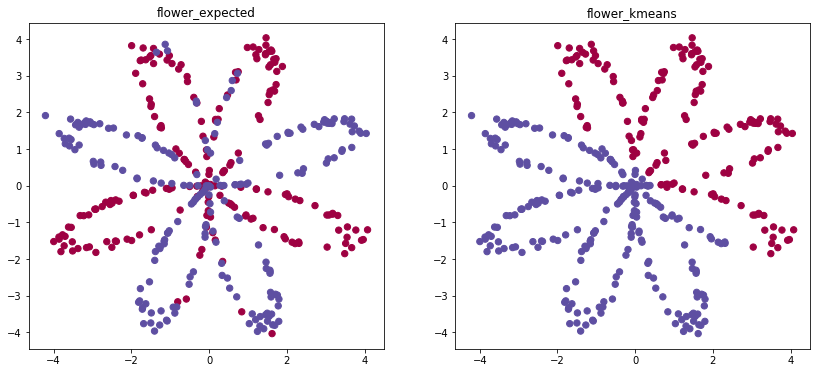

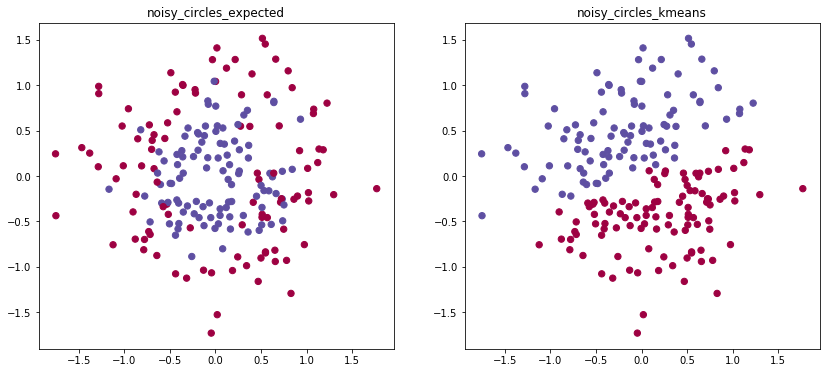

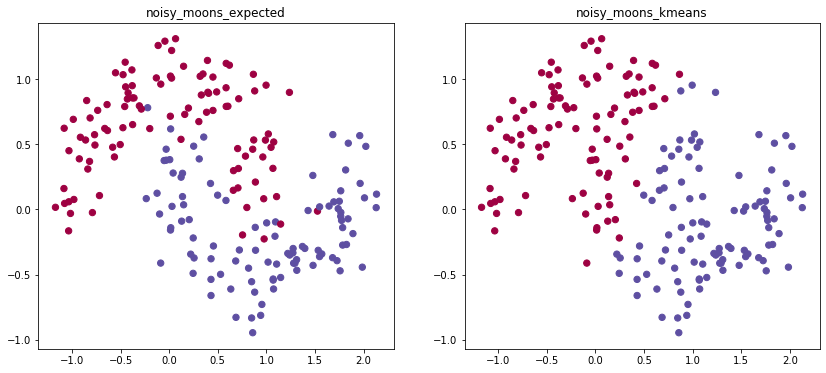

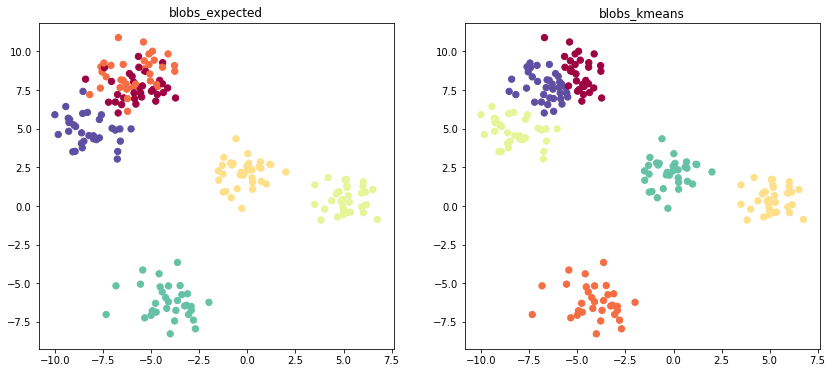

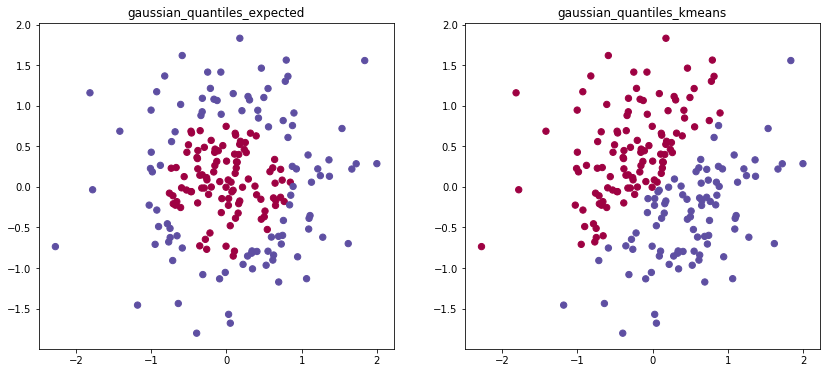

In [77]:
for name, X, Y in datas:
    plt.figure(figsize=(14,6))

    
    axes1 = plt.subplot(1, 2, 1)
    axes1.scatter(X[:, 0], X[:, 1], c=Y, s=40, cmap=plt.cm.Spectral)
    plt.title(name + "_expected")
    
    axes2 = plt.subplot(1, 2, 2)
    n_clusters = len(set(Y))
    kmeans = KMeans(n_clusters=n_clusters, random_state=0).fit_predict(X)
    axes2.scatter(X[:, 0], X[:, 1], c=kmeans, s=40, cmap=plt.cm.Spectral);
    plt.title(name+'_kmeans')

    plt.show()

In [78]:
# iris_X
# set(iris_Y)
 len(set(iris_Y))

3

In [79]:
# 請使用kmeans將iris_X進行分群(注意:random_state=0)
#=============your works starts===============#
n_clusters = len(set(iris_Y))
kmeans_Y = KMeans(n_clusters=n_clusters, random_state=0).fit_predict(X)
#==============your works ends================#

np.random.seed(1212)
print(kmeans_Y[np.random.randint(149, size=10)])
# # [2 0 0 2 2 1 1 1 1 0]


[0 1 2 2 0 2 2 2 1 0]


ValueError: 'c' argument has 200 elements, which is not acceptable for use with 'x' with size 150, 'y' with size 150.

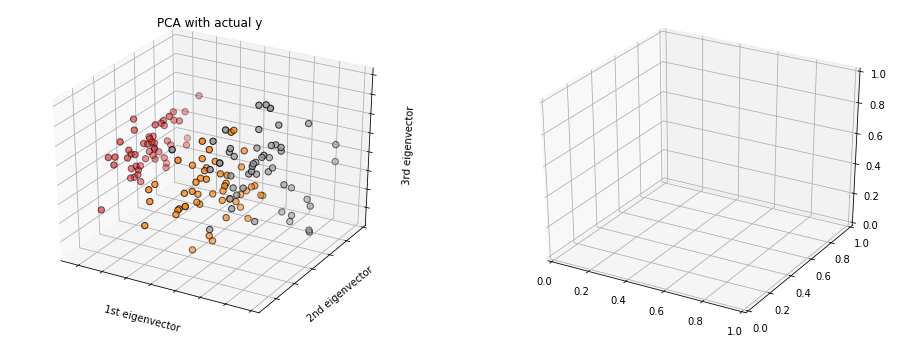

In [80]:
# actual 
def plot_iris_predict_acc(predict_Y):
    X = iris_X
    Y = iris_Y
    fig = plt.figure(1, figsize=(16, 6))
    ax = fig.add_subplot(1, 2, 1, projection='3d')
    X_reduced = PCA(n_components=3).fit_transform(X)
    ax.scatter(X_reduced[:, 0], X_reduced[:, 1], X_reduced[:, 2], c=Y,
               cmap=plt.cm.Set1, edgecolor='k', s=40)
    ax.set_title("PCA with actual y")
    ax.set_xlabel("1st eigenvector")
    ax.w_xaxis.set_ticklabels([])
    ax.set_ylabel("2nd eigenvector")
    ax.w_yaxis.set_ticklabels([])
    ax.set_zlabel("3rd eigenvector")
    ax.w_zaxis.set_ticklabels([])

    # predict
    X = iris_X
    Y = predict_Y
    fig = plt.figure(1, figsize=(16, 6))
    ax = fig.add_subplot(1, 2, 2, projection='3d')
    X_reduced = PCA(n_components=3).fit_transform(X)
    ax.scatter(X_reduced[:, 0], X_reduced[:, 1], X_reduced[:, 2], c=Y,
               cmap=plt.cm.Set1, edgecolor='k', s=40)
    ax.set_title("PCA with predicted y")
    ax.set_xlabel("1st eigenvector")
    ax.w_xaxis.set_ticklabels([])
    ax.set_ylabel("2nd eigenvector")
    ax.w_yaxis.set_ticklabels([])
    ax.set_zlabel("3rd eigenvector")
    ax.w_zaxis.set_ticklabels([])

    plt.show()
    
np.random.seed(1212)
plot_iris_predict_acc(kmeans_Y)

In [ ]:
np.random.seed(2424)
n_samples = 40
n_features = 100
n_means = 3

np.random.random((n_samples, n_features)).shape
np.random.random((n_means, n_features)).shape

In [93]:
# curve the k-means algorithm
from sklearn.metrics.pairwise import euclidean_distances
np.random.seed(2424)
n_samples = 40
n_features = 100
n_means = 3

# initialize your X and means using np.random.random()
#=============your works starts===============#
X = np.random.random((n_samples, n_features))
means = np.random.random((n_means, n_features))
#==============your works ends================#

print(X.shape)
print(means.shape)
# (40, 100)
# (3, 100)

(40, 100)
(3, 100)


In [ ]:
# %matplotlib notebook
%matplotlib inline

fig = plt.figure(1, figsize=(8, 6))
ax = Axes3D(fig, elev=-150, azim=110)
X_reduced = PCA(n_components=3).fit_transform(np.concatenate([X, means], axis=0))
ax.scatter(X_reduced[:n_samples, 0], X_reduced[:n_samples, 1], X_reduced[:n_samples, 2], c='blue', cmap=plt.cm.Set1, edgecolor='k', s=40)
ax.scatter(X_reduced[n_samples:, 0], X_reduced[n_samples:, 1], X_reduced[n_samples:, 2], c='red', cmap=plt.cm.Set1, edgecolor='k', s=40)
ax.set_title("First three PCA directions")
ax.set_xlabel("1st eigenvector")
ax.w_xaxis.set_ticklabels([])
ax.set_ylabel("2nd eigenvector")
ax.w_yaxis.set_ticklabels([])
ax.set_zlabel("3rd eigenvector")
ax.w_zaxis.set_ticklabels([])
plt.show()

In [83]:
#def cal_dist(p1, p2):
#    return np.sqrt(np.sum(np.square(p2-p1)))
# X[0].shape, means[0].shape
# cal_dist(X[0], means[0])

ValueError: operands could not be broadcast together with shapes (100,) (2,) 

In [58]:
from sklearn.metrics.pairwise import euclidean_distances

In [59]:
# find the distance between each sample and mean(hint: euclidean_distances)
#=============your works starts===============#
distances = euclidean_distances(X, means)
#==============your works ends================#

print(distances.shape)
# (40, 3)

(40, 3)


In [90]:
for i in range(40):
    print(i, distances[1], np.min(distances[1]), np.where(distances[i] == np.min(distances[i])))

0 [4.39685438 3.90884002 4.39555572] 3.908840015566593 (array([1], dtype=int64),)
1 [4.39685438 3.90884002 4.39555572] 3.908840015566593 (array([1], dtype=int64),)
2 [4.39685438 3.90884002 4.39555572] 3.908840015566593 (array([2], dtype=int64),)
3 [4.39685438 3.90884002 4.39555572] 3.908840015566593 (array([1], dtype=int64),)
4 [4.39685438 3.90884002 4.39555572] 3.908840015566593 (array([2], dtype=int64),)
5 [4.39685438 3.90884002 4.39555572] 3.908840015566593 (array([1], dtype=int64),)
6 [4.39685438 3.90884002 4.39555572] 3.908840015566593 (array([0], dtype=int64),)
7 [4.39685438 3.90884002 4.39555572] 3.908840015566593 (array([2], dtype=int64),)
8 [4.39685438 3.90884002 4.39555572] 3.908840015566593 (array([0], dtype=int64),)
9 [4.39685438 3.90884002 4.39555572] 3.908840015566593 (array([1], dtype=int64),)
10 [4.39685438 3.90884002 4.39555572] 3.908840015566593 (array([0], dtype=int64),)
11 [4.39685438 3.90884002 4.39555572] 3.908840015566593 (array([0], dtype=int64),)
12 [4.39685438

In [85]:
np.argmin(distances, axis = 1 )

array([1, 1, 2, 1, 2, 1, 0, 2, 0, 1, 0, 0, 1, 0, 0, 2, 2, 2, 2, 1, 0, 2,
       2, 2, 2, 0, 2, 1, 0, 0, 0, 0, 0, 0, 1, 0, 2, 0, 0, 2], dtype=int64)

In [87]:
# get the nearest mean index(0,1,2) for each sample (hint: np.argmin)
#=============your works starts===============#
nearest_mean_index = np.argmin(distances, axis = 1 )
#==============your works ends================#

print(nearest_mean_index.shape)
# (40,)

(40,)


In [97]:
nearest_mean_index

array([1, 1, 2, 1, 2, 1, 0, 2, 0, 1, 0, 0, 1, 0, 0, 2, 2, 2, 2, 1, 0, 2,
       2, 2, 2, 0, 2, 1, 0, 0, 0, 0, 0, 0, 1, 0, 2, 0, 0, 2], dtype=int64)

In [94]:
[X[nearest_mean_index==i] for i in range(n_means)]

[array([[0.68752053, 0.54798924, 0.99087163, ..., 0.750216  , 0.1210328 ,
         0.92191567],
        [0.86963537, 0.17927041, 0.43502994, ..., 0.65832533, 0.69562112,
         0.81025208],
        [0.71660455, 0.58610103, 0.98037674, ..., 0.63962904, 0.858845  ,
         0.8166406 ],
        ...,
        [0.49640107, 0.44746322, 0.59122535, ..., 0.78481156, 0.04177281,
         0.7468995 ],
        [0.68657732, 0.64888526, 0.0469417 , ..., 0.48775615, 0.0748065 ,
         0.70355391],
        [0.74321169, 0.42644326, 0.82707119, ..., 0.97354894, 0.78268063,
         0.75353693]]),
 array([[8.43394002e-01, 7.39468297e-01, 1.30761069e-02, 8.92208611e-01,
         9.02618161e-01, 6.65021235e-01, 6.36564655e-01, 6.49434863e-01,
         8.82786420e-01, 5.42058072e-01, 6.85361042e-01, 3.52802553e-01,
         3.67481529e-01, 7.86460498e-01, 1.02502180e-01, 4.64469949e-01,
         8.83016480e-01, 5.38461878e-01, 7.44648710e-04, 8.97914052e-01,
         2.20158116e-01, 7.53721208e-01, 8.8

In [95]:
# find the X belong to each cluster
#=============your works starts===============#
X_belong_cluster_n = [X[nearest_mean_index==i] for i in range(n_means)]
#==============your works ends================#

print(len(X_belong_cluster_n))
print(X_belong_cluster_n[0].shape)
print(X_belong_cluster_n[1].shape)
print(X_belong_cluster_n[2].shape)

# 3
# (17, 100)
# (9, 100)
# (14, 100)

3
(17, 100)
(9, 100)
(14, 100)


In [101]:
for x in X_belong_cluster_n:
    print(x.shape)
    print(np.mean(x, axis=0).shape)

(17, 100)
(100,)
(9, 100)
(100,)
(14, 100)
(100,)


In [98]:
# find new mean for each cluster
# and reshape into (3, 100)
#=============your works starts===============#
new_means = [np.mean(x, axis=0) for x in X_belong_cluster_n]
new_means = np.array(new_means)
#==============your works ends================#

print(new_means.shape)
# (3, 100)

(3, 100)


## 2. Hierarchical Clustering
### steps
hierarchical的分群方法，步驟簡述如下，可參考下圖(取自維基百科):

    1. 把每一個點當作一個群組
    2. 透過掃描過整個資料及尋找出最近的兩個群組，並把這兩個點榜再一起變成一個群組
    3. 尋找下一個最近的的兩個群組，再綁再一起變成一個群組
    4. ....
    5. 停止: 直到所有資料都被分成一群，或是透過設定參數到分到幾個群時自動停止

![hierarchical](./imgs/Hierarchical_clustering.svg.png)

### parameters

1. table

參數 | 意義
--- | ---
linkage | 如何衡量群與群之間的距離。(註解)
n_clusters | 分成幾個群

2. 註解:
    - ward(single): 兩個群中最近的點。
    - complete: 兩個群中最遠的點。
    - average:兩個群的重心。

### pros & cons

1. 比較耗效能: 因為有100萬筆資料，就要跑100萬次迴圈，每一次迴圈都要掃描過每一筆資料，才能跑完。
2. 很適合用來做生物分類，因為它可以完整畫出分類樹狀圖。

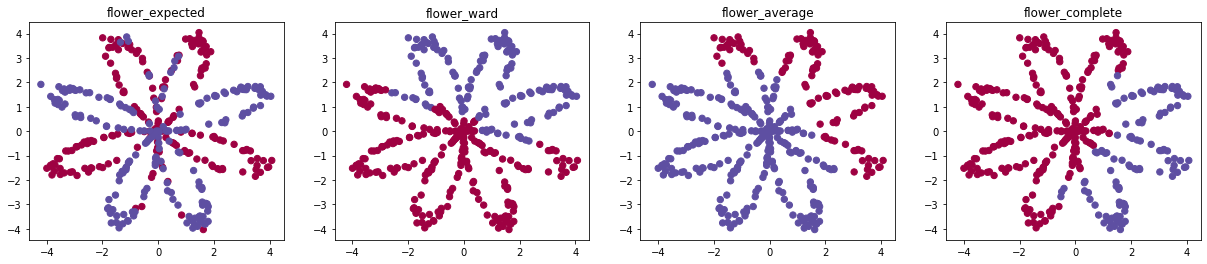

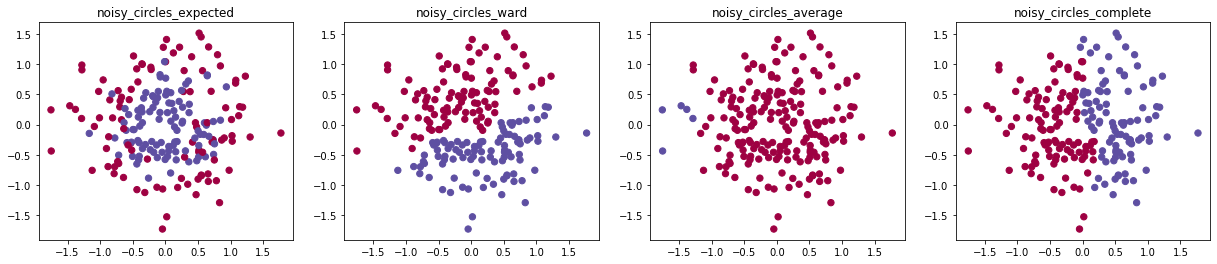

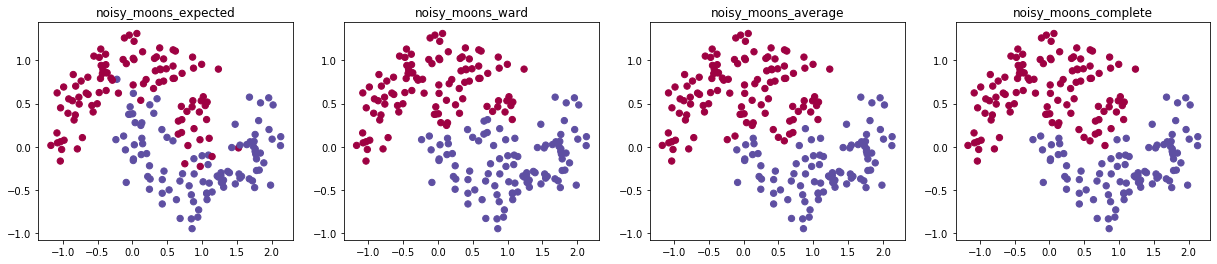

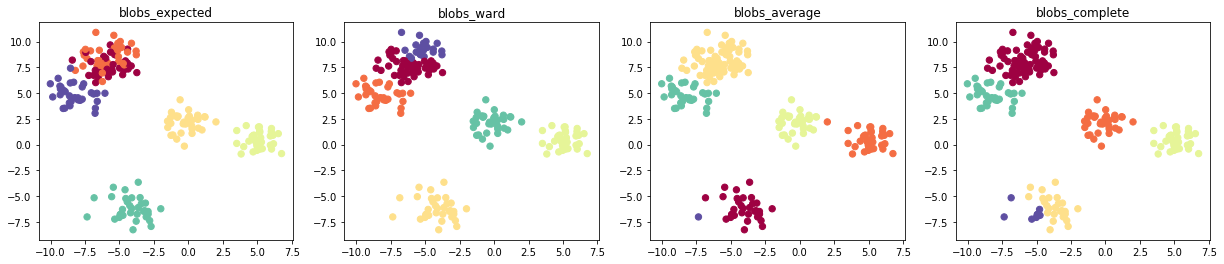

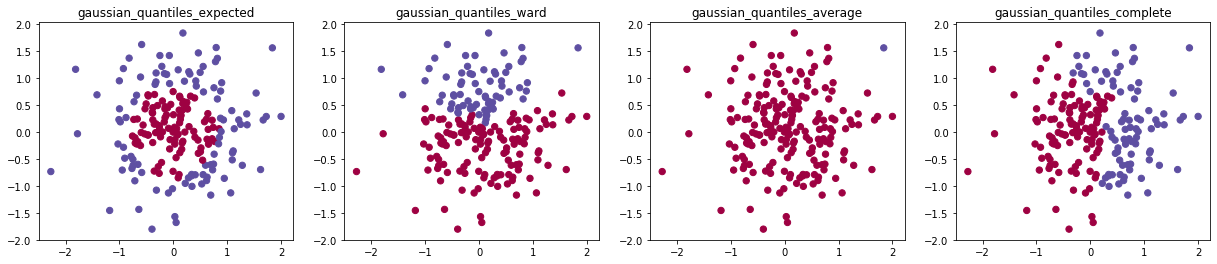

In [102]:
linkage = ['ward', 'average', 'complete']
for name, X, Y in datas:
    
    plt.figure(figsize=(21,4))

    axes1 = plt.subplot(1, 4, 1)
    axes1.scatter(X[:, 0], X[:, 1], c=Y, s=40, cmap=plt.cm.Spectral)
    plt.title(name+'_expected')

    axes2 = plt.subplot(1, 4, 2)
    n_clusters = len(set(Y))
    hierarchy = AgglomerativeClustering(linkage=linkage[0], n_clusters=n_clusters).fit_predict(X)
    axes2.scatter(X[:, 0], X[:, 1], c=hierarchy, s=40, cmap=plt.cm.Spectral);
    plt.title(name+'_' + linkage[0])

    axes3 = plt.subplot(1, 4, 3)
    n_clusters = len(set(Y))
    hierarchy = AgglomerativeClustering(linkage=linkage[1], n_clusters=n_clusters).fit_predict(X)
    axes3.scatter(X[:, 0], X[:, 1], c=hierarchy, s=40, cmap=plt.cm.Spectral);
    plt.title(name+'_' + linkage[1])

    
    axes4 = plt.subplot(1, 4, 4)
    n_clusters = len(set(Y))
    hierarchy = AgglomerativeClustering(linkage=linkage[2], n_clusters=n_clusters).fit_predict(X)
    axes4.scatter(X[:, 0], X[:, 1], c=hierarchy, s=40, cmap=plt.cm.Spectral);
    plt.title(name+'_' + linkage[2])

    
    
    plt.show()

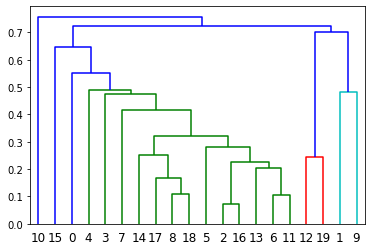

In [103]:
# Other Method (參考就好)
from scipy.cluster.hierarchy import dendrogram, linkage
Z = linkage(X[:20], 'single')
plt.figure()
dn = dendrogram(Z)
plt.show() 

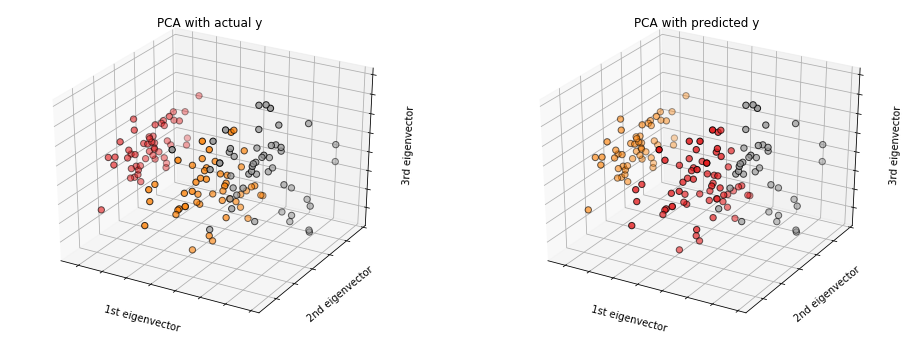

In [104]:
# 請用AgglomerativeClustering(linkage='average')將iris_X進行分群
#=============your works starts===============#
n_clusters = len(set(iris_Y))
hierarchy_Y = AgglomerativeClustering(n_clusters=n_clusters, linkage='average').fit_predict(iris_X)
#==============your works ends================#


plot_iris_predict_acc(hierarchy_Y)

## 3. Density Based Clustering (DBSCAN)
### steps
顧名思義，這種分群演算法計算的是密度，透過設定多長的半徑內，有出現幾個點，不斷延伸，延伸到無法延伸，所有出現在前面延伸範圍的點分成一個群組，請見下圖(取自[stackexchange](https://stats.stackexchange.com/questions/194734/dbscan-what-is-a-core-point))。

![DBSCAN](./imgs/dbscan.png)

### parameters
參數 | 意義
--- | ---
eps | 半徑
min_samples | 半徑內要出線的點的個數



### pros & cons
1. 常常用來偵測Noisy Data。
2. 無法設定要分成幾個群。

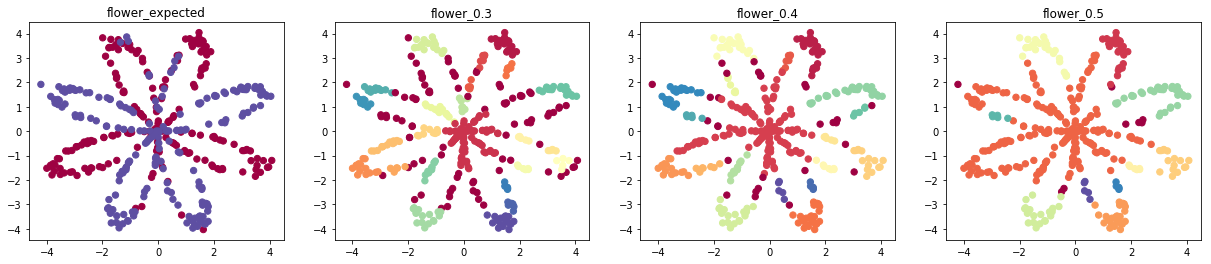

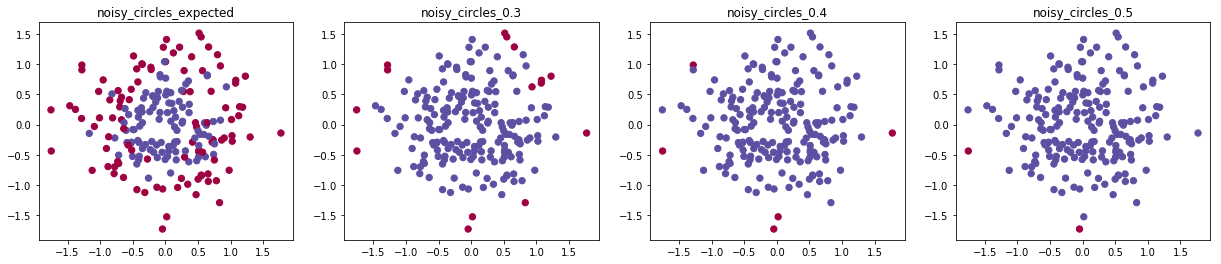

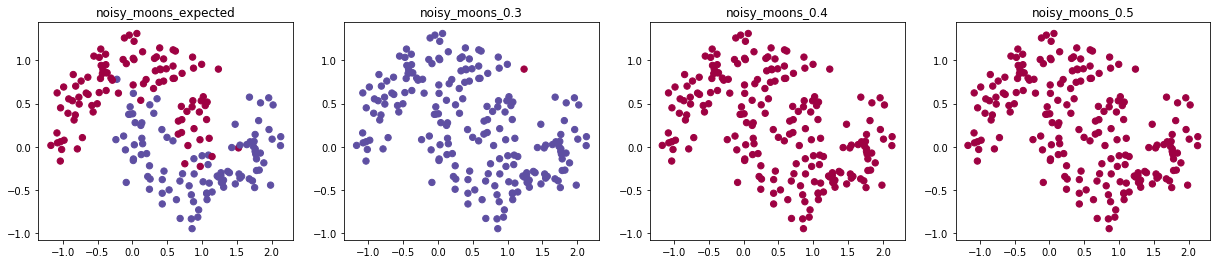

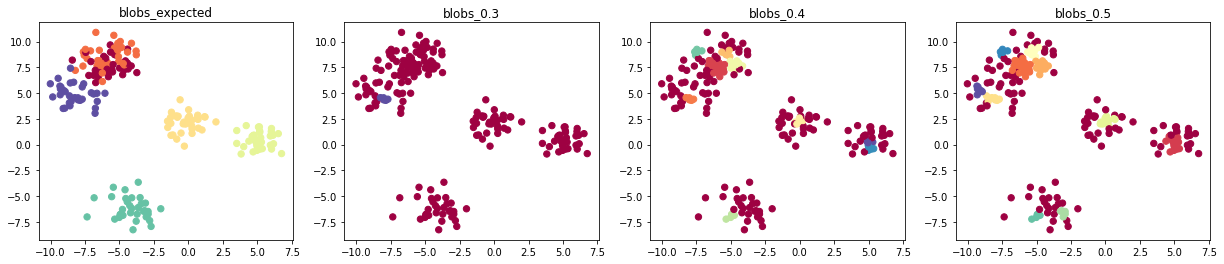

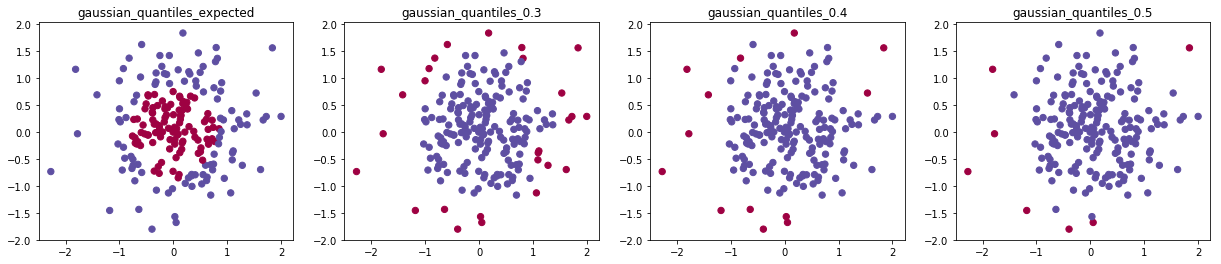

In [19]:
epss = [0.3, 0.4, 0.5]
for name, X, Y in datas:
    
    plt.figure(figsize=(21,4))

    
    axes1 = plt.subplot(1, 4, 1)
    axes1.scatter(X[:, 0], X[:, 1], c=Y, s=40, cmap=plt.cm.Spectral)
    plt.title(name+'_expected')
    
    
    axes2 = plt.subplot(1, 4, 2)
    dbscan = DBSCAN(eps=epss[0]).fit_predict(X)
    axes2.scatter(X[:, 0], X[:, 1], c=dbscan, s=40, cmap=plt.cm.Spectral)
    plt.title(name+'_'+str(epss[0]))


    axes3 = plt.subplot(1, 4, 3)
    dbscan = DBSCAN(eps=epss[1]).fit_predict(X)
    axes3.scatter(X[:, 0], X[:, 1], c=dbscan, s=40, cmap=plt.cm.Spectral)
    plt.title(name+'_'+str(epss[1]))

    
    axes3 = plt.subplot(1, 4, 4)
    dbscan = DBSCAN(eps=epss[2]).fit_predict(X)
    axes3.scatter(X[:, 0], X[:, 1], c=dbscan, s=40, cmap=plt.cm.Spectral)
    plt.title(name+'_'+str(epss[2]))

        
    plt.show()

In [ ]:
from sklearn.cluster import DBSCAN

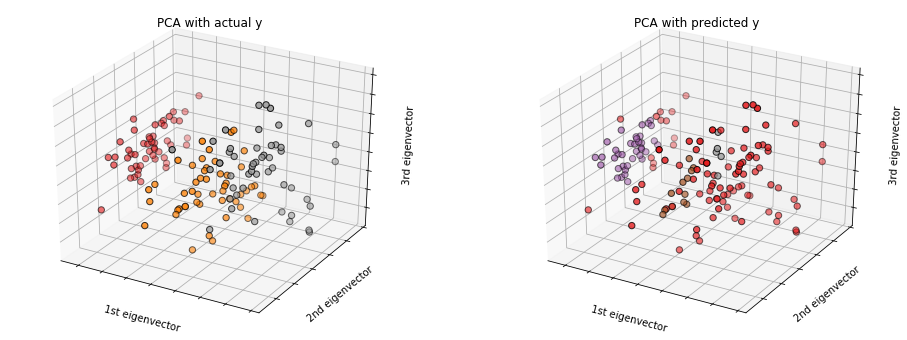

In [111]:
# 請用DBSCAN(eps=0.3)將iris_X進行分群
#=============your works starts===============#
dbscan_Y = DBSCAN(eps=0.3, min_samples=5).fit_predict(iris_X)
#==============your works ends================#

plot_iris_predict_acc(dbscan_Y)